<a href="https://colab.research.google.com/github/Eshaan416/rl-assignment-1/blob/main/RL_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [178]:
random.seed(30)

In [179]:
class State:
    def __init__(self, name, is_terminal):
        self.name = name
        self.is_terminal = is_terminal
        self.actions = []

    def choose_action(self, e):
        rand_val = random.random()
        if rand_val < e:
            return self.actions[int(random.random() * len(self.actions))]
        else:
            best_action = None
            for action in self.actions:
                if (best_action == None) or (sum(action.q) > sum(best_action.q)):
                    best_action = action
            return best_action

    def get_best_action_val(self, degree, i):
        best_action = None
        if degree == 1:
            j = 0
        else:
            j = [k for k in range(degree) if k != i][int(random.random() * (degree - 1))]
        for action in self.actions:
            if (best_action == None) or (action.q[i] > best_action.q[i]):
                best_action = action
        return best_action.q[j]

In [180]:
class Trans:
    def __init__(self, prob, to_state, reward):
        self.prob = prob
        self.to_state = to_state
        self.reward = reward

In [181]:
class Action:
    def __init__(self, name, trans_list, degree):
        self.name = name
        self.trans_list = trans_list
        self.q = [0 for _ in range(degree)]

    def take(self):
        rand_val = random.random()
        accum = 0
        for trans in self.trans_list:
            if (rand_val >= accum) and (rand_val < (accum + trans.prob)):
                return trans
            accum += trans.prob

    def update_val(self, alpha, reward, gamma, next_state):
        i = int(random.random() * len(self.q))
        self.q[i] += alpha * (reward + (gamma * next_state.get_best_action_val(len(self.q), i)) - self.q[i])

In [182]:
class Environment:
    def __init__(self, grid, degree):
        self.states = dict()

        for x in range(grid.n):
            for y in range(grid.m):
                if grid.get_type(x, y) != 'X':
                    self.states[x, y] = State((x, y), (x, y) == grid.term_pos)

        self.init_state = self.states[grid.init_pos]
        self.degree = degree

        for x in range(grid.n):
            for y in range(grid.m):
                if grid.get_type(x, y) == 'X':
                    continue

                for move in [('up', -1, 0), ('up-right', -1, 1), ('right', 0, 1), ('down-right', 1, 1), ('down', 1, 0), ('down-left', 1, -1), ('left', 0, -1), ('up-left', -1, -1)]:
                    name, i, j = move

                    if grid.get_type(x + i, y + j) == 'X':
                        trans_list = [Trans(1, self.init_state, -100)]

                    elif grid.get_type(x + i, y + j) == 'S':
                        trans_list = [Trans(0.8, self.states[x + i, y + j], 100 if self.states[x + i, y + j].is_terminal else -1)]

                        if grid.get_type(x + (i * 2), y + (j * 2)) == 'X':
                            trans_list.append(Trans(0.2, self.init_state, -100))
                        else:
                            trans_list.append(Trans(0.2, self.states[x + (i * 2), y + (j * 2)], 100 if self.states[x + (i * 2), y + (j * 2)].is_terminal else -1))

                    else:
                        trans_list = [Trans(1, self.states[x + i, y + j], 100 if self.states[x + i, y + j].is_terminal else -1)]

                    self.states[x, y].actions.append(Action(name, trans_list, degree))

    def train_episode(self, max_length, epsilon, alpha, gamma):
        curr_state = self.init_state
        count = max_length
        total_reward = 0

        while not curr_state.is_terminal:
            action = curr_state.choose_action(epsilon)
            trans = action.take()
            next_state, reward = trans.to_state, trans.reward
            action.update_val(alpha, reward, gamma, next_state)
            curr_state = next_state
            total_reward += reward

            count -= 1
            if count == 0:
                break

        return total_reward

    def test_episode(self, max_length, alpha, gamma):
        curr_state = self.init_state
        count = max_length

        while not curr_state.is_terminal:
            action = curr_state.choose_action(0)
            trans = action.take()
            next_state, reward = trans.to_state, trans.reward
            print((curr_state.name, action.name, reward, next_state.name))
            curr_state = next_state

            count -= 1
            if count == 0:
                break

    def train(self, num_episodes, max_length, epsilon, alpha, gamma):
        total_reward_list = []
        for _ in tqdm(range(num_episodes)):
            total_reward = self.train_episode(max_length, epsilon, alpha, gamma)
            total_reward_list.append(total_reward)
        return total_reward_list

In [183]:
class Grid:
    def __init__(self, base, init_pos, term_pos):
        self.n, self.m = len(base), len(base[0])
        self.base = base
        self.init_pos = init_pos
        self.term_pos = term_pos

    def get_type(self, x, y):
        if not ((x >= 0) and (x < self.n) and (y >= 0) and (y < self.m)):
            return 'X'
        else:
            return self.base[x][y]

In [184]:
grid = Grid([
    '.SXXXX....',
    '..SXSSX.X.',
    '...X..XXS.',
    '...SXS.X..',
    '...SXX..XS',
    '...XXXX...',
    '...SXX....',
    '..........',
    'XS...S..XX',
    'XX....SXXX'
], (0, 0), (2, 9))
"""
grid = Grid([
    '..SSX..S.X',
    '.SXX.S.XS.',
    'S.X..SS.X.',
    'S..SX.X.S.',
    '.S.X..SX..',
    'S...SSX.X.',
    '..SXXXXXXS',
    'S.XX.S...X',
    '..XS...S..',
    '......S...'
], (0, 0), (7, 7))"""

performance_list = []

In [185]:
env = Environment(grid, 1)
performance_list.append(env.train(1000, 2000, 0.1, 0.1, 0.9))
env.test_episode(20, 0.1, 0.9)

100%|██████████| 1000/1000 [00:00<00:00, 6634.39it/s]

((0, 0), 'down-right', -1, (1, 1))
((1, 1), 'down', -1, (2, 1))
((2, 1), 'down-right', -1, (3, 2))
((3, 2), 'down', -1, (4, 2))
((4, 2), 'up-right', -1, (3, 3))
((3, 3), 'up-right', -1, (2, 4))
((2, 4), 'right', -1, (2, 5))
((2, 5), 'down-right', -1, (3, 6))
((3, 6), 'down-right', -1, (4, 7))
((4, 7), 'up-right', -1, (3, 8))
((3, 8), 'up-right', 100, (2, 9))


In [186]:
env = Environment(grid, 2)
performance_list.append(env.train(1000, 2000, 0.1, 0.1, 0.9))
env.test_episode(20, 0.1, 0.9)

100%|██████████| 1000/1000 [00:00<00:00, 4345.93it/s]

((0, 0), 'down-right', -1, (1, 1))
((1, 1), 'down-left', -1, (2, 0))
((2, 0), 'down', -1, (3, 0))
((3, 0), 'down-right', -1, (4, 1))
((4, 1), 'down-left', -1, (5, 0))
((5, 0), 'down-right', -1, (6, 1))
((6, 1), 'down-right', -1, (7, 2))
((7, 2), 'right', -1, (7, 3))
((7, 3), 'right', -1, (7, 4))
((7, 4), 'right', -1, (7, 5))
((7, 5), 'up-right', -1, (6, 6))
((6, 6), 'up-right', -1, (5, 7))
((5, 7), 'up', -1, (4, 7))
((4, 7), 'up-right', -1, (3, 8))
((3, 8), 'up-right', 100, (2, 9))


In [187]:
env = Environment(grid, 3)
performance_list.append(env.train(1000, 2000, 0.1, 0.1, 0.9))
env.test_episode(20, 0.1, 0.9)

100%|██████████| 1000/1000 [00:00<00:00, 4418.65it/s]

((0, 0), 'down-right', -1, (1, 1))
((1, 1), 'down', -1, (2, 1))
((2, 1), 'down-left', -1, (3, 0))
((3, 0), 'down-right', -1, (4, 1))
((4, 1), 'down', -1, (5, 1))
((5, 1), 'down', -1, (6, 1))
((6, 1), 'down-right', -1, (7, 2))
((7, 2), 'down-right', -1, (8, 3))
((8, 3), 'right', -1, (8, 4))
((8, 4), 'right', -1, (8, 5))
((8, 5), 'up-right', -1, (7, 6))
((7, 6), 'up', -1, (6, 6))
((6, 6), 'up-right', -1, (5, 7))
((5, 7), 'up', -1, (4, 7))
((4, 7), 'up-right', -1, (3, 8))
((3, 8), 'up-right', 100, (2, 9))


In [188]:
env = Environment(grid, 4)
performance_list.append(env.train(1000, 2000, 0.1, 0.1, 0.9))
env.test_episode(20, 0.1, 0.9)

100%|██████████| 1000/1000 [00:00<00:00, 3805.36it/s]

((0, 0), 'down-right', -1, (1, 1))
((1, 1), 'down', -1, (2, 1))
((2, 1), 'down', -1, (3, 1))
((3, 1), 'down-right', -1, (4, 2))
((4, 2), 'up-right', -1, (3, 3))
((3, 3), 'up-right', -1, (2, 4))
((2, 4), 'right', -1, (2, 5))
((2, 5), 'down-right', -1, (3, 6))
((3, 6), 'down-right', -1, (4, 7))
((4, 7), 'up-right', -1, (3, 8))
((3, 8), 'up-right', 100, (2, 9))


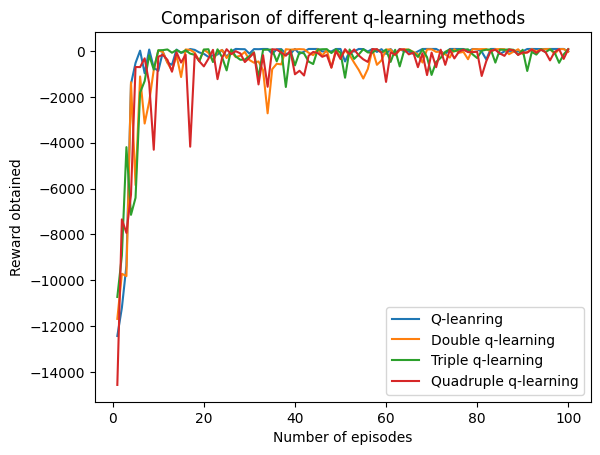

In [190]:
labels = ['Q-leanring', 'Double q-learning', 'Triple q-learning', 'Quadruple q-learning']
for i, total_reward_list in enumerate(performance_list):
    plt.plot([((i + 1) * 1) for i in range(100)], [(sum(total_reward_list[(i * 1) : ((i + 1) * 1)]) / 1) for i in range(100)], label=labels[i])
plt.title('Comparison of different q-learning methods')
plt.xlabel('Number of episodes')
plt.ylabel('Reward obtained')
plt.legend()